# Import

In [140]:
import csv
import itertools
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from tqdm import tqdm

## Add configuration file

In [141]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")

In [142]:
from ALL import config 
from util import *

## Set condition

In [143]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

# Read data

In [222]:
color_iter = itertools.cycle(["orange", "c"])

In [372]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.9, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.6)
        splot.add_artist(ell)

    splot.spines["top"].set_visible(False)
    splot.spines["right"].set_visible(False)
    splot.spines["left"].set_visible(False)
    splot.spines["bottom"].set_visible(False)

#     plt.xlim(-9.0, .0)
#     plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
#     plt.title(title)
    plt.savefig("gmm.pdf")

In [373]:
# Number of samples per component
n_samples = 1000

In [374]:
# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -1], [-1, 0]])
D = np.array([[1.0, 0.0], [0.0, 1.0]])
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), C),
    np.dot(np.random.randn(n_samples, 2), D) + np.array([3, 3]),
]


In [375]:
np.random.seed(0)
C = np.array([[20, 0], [0, 0.1]])
D = np.array([[1, 0], [0, 1]])
X = np.r_[
    np.random.multivariate_normal([-3, -3], C, n_samples),
    np.random.multivariate_normal([0, 0], D, n_samples)
]


In [376]:
X.shape

(2000, 2)

In [377]:
X_rand = np.random.gamma(5, 1, (n_samples, 2))

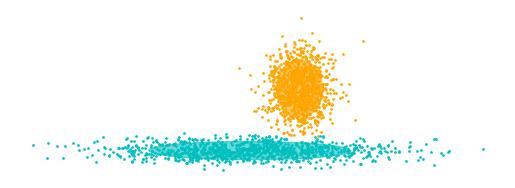

In [378]:
# Fit a Gaussian mixture with EM using five components
gmm = GaussianMixture(n_components=2, covariance_type="full").fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


ValueError: expected square "a" matrix

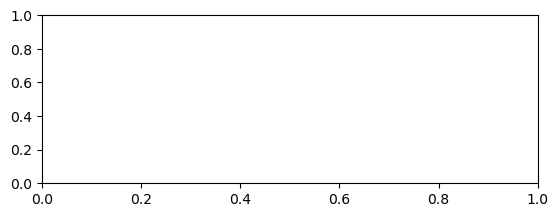

In [117]:
# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=10e-20,
    covariance_type="full",
    max_iter=1000,
    init_params="k-means++",
    n_init=1,
#     mean_precision_prior=1,
    
).fit(X_rand)
plot_results(
    X_rand,
    dpgmm.predict(X_rand),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

In [ ]:
set(dpgmm.predict(X_rand))